In [24]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [25]:
df = pd.read_csv('dataset.csv', index_col='Month', parse_dates=True,date_parser=lambda x: pd.to_datetime(x, format='%y-%b'))


In [26]:
# Initialise for future use

production = df['Production']
withdrawals = df['Withdrawals']
globalPrice = df['GlobalPrice']
exchangeRate = df['ExchangeRate']
temperature = df['TempMax']
precipitation = df['Precipitation']

In [27]:
# ADF test for stationarity

def ADF_test(df):
    p = adfuller(df)[1]
    print(f'P-value: {p} < 0.05')
    if p < 0.05:
        print('The time series is stationary')
    else:
        print('The time series is not stationary')

In [28]:
# Optional Differencing

def Differencing(df, lags):
    df_diff = df.diff(lags).dropna()
    df_diff.plot(), ADF_test(df_diff)

In [29]:
# Train test Split

def train_test_split(df, test_size):
    total = len(df)
    train_size = int(total - test_size)

    train = df.iloc[:train_size]
    test = df.iloc[train_size:]

    return train, test

In [30]:
# Finding the best order using RMSE

def Order_RMSE(train, test, p_range, d_range, q_range):
    best_score, best_order = float("inf"), None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                order = (p,d,q)
                try:
                    model = ARIMA(train, order=order)
                    model_fit = model.fit()
                    predicted = model_fit.forecast(steps=len(test))
                    rmse = ((predicted - test) ** 2).mean() ** 0.5
                    if rmse < best_score:
                        best_score, best_order = rmse, order
                except:
                    continue
    print(f'Best ARIMA{best_order} RMSE={best_score}')

In [31]:
# Finding the best order using AIC 

def Order_AIC(train, test, p_range, d_range, q_range):
    best_score, best_order = float("inf"), None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                order = (p,d,q)
                try:
                    model = ARIMA(train, order=order)
                    model_fit = model.fit()
                    aic = model_fit.aic
                    if aic < best_score:
                        best_score, best_order = aic, order
                except:
                    continue
    print(f'Best ARIMA{best_order} AIC={best_score}')

In [32]:
# Modelling 

def Model(train, test, order):
    model = ARIMA(train, order=order).fit()

    start = len(train)
    end = start + len(test) - 1

    pred= model.predict(start=start, end=end, typ='levels', dynamic=False).rename('Forecast')

    pred.plot(legend=True)
    test.plot(legend=True)

    # Compare the forecast with the test set
    pred.apply(lambda x: f"{x:.2f}")
    for i in range(len(pred)):
        print(f'Actual: {test[i]}, Predicted: {pred[i]}')
    

In [33]:
# Evaluate the model using AIC, BIC, MSE, RMSE, MAE, MAPE

def Evaluate(train, test, order):
    model = ARIMA(train, order=order).fit()
    pred = model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels', dynamic=False).rename('Forecast')

    mse = ((pred - test) ** 2).mean()
    rmse = mse ** 0.5
    mae = (abs(pred - test)).mean()
    mape = (abs(pred - test) / abs(test)).mean() * 100


    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')
    print(f'AIC: {model.aic}')
    print(f'BIC: {model.bic}')


In [34]:
# Forecasting 

def Forecast(df, order, months):

    final_model = ARIMA(df, order = order).fit()
    forecast = final_model.forecast(steps=months).rename('Forecast')
    # forecast.apply(lambda x: f"{x:.2f}")
    
    return forecast

In [35]:
def Forecasted_plot(actual, forecasted):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(forecasted, label='Forecasted', color='red')
    plt.title('Forecast vs Actual')
    plt.legend()
    plt.show()

# Log Transform Production data

In [36]:
def log(df):
    df_log = np.log(df)
    return df_log

In [37]:
def exp(df):
    df_exp = np.exp(df)
    return df_exp

Month
2014-09-01    13.195186
2014-10-01    14.299833
2014-11-01    14.638388
2014-12-01    14.614815
2015-01-01    14.630704
                ...    
2024-04-01    14.205298
2024-05-01    13.288603
2024-06-01    13.062116
2024-07-01    12.991156
2024-08-01    13.490046
Name: Production, Length: 120, dtype: float64

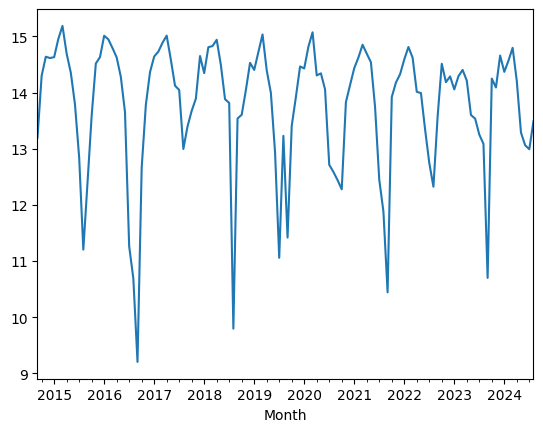

In [38]:
log_production = log(production)
log_production.plot()
log_production

In [39]:
ADF_test(log_production)

P-value: 0.008007233346225941 < 0.05
The time series is stationary


In [40]:
prod_train, prod_test = train_test_split(log_production, 24)

In [41]:
Order_RMSE(prod_train, prod_test, range(0, 5), range(0, 2), range(0, 5))
Order_AIC(prod_train, prod_test, range(0, 5), range(0, 2), range(0, 5))

Best ARIMA(4, 0, 1) RMSE=0.735526666344571
Best ARIMA(3, 0, 2) AIC=236.23807683158776


In [42]:
Evaluate(prod_train, prod_test, (4, 0, 1))

MSE: 0.5409994769039578
MAE: 0.5022316006672155
RMSE: 0.735526666344571
MAPE: 3.8226465754397756
AIC: 249.10965354710982
BIC: 267.06009088738466


In [43]:
Evaluate(prod_train, prod_test, (3,0,2 ))

MSE: 0.6372469517626517
MAE: 0.6715001901390298
RMSE: 0.7982774904521933
MAPE: 4.969295585327071
AIC: 236.23807683158776
BIC: 254.1885141718626


Actual: 13.569762181863217, Predicted: 12.819808948682155
Actual: 14.512411683647114, Predicted: 13.234356346140201
Actual: 14.184932512458685, Predicted: 13.79302405833821
Actual: 14.287478506670679, Predicted: 14.243216253232568
Actual: 14.056266103595256, Predicted: 14.522006400689321
Actual: 14.291785108816498, Predicted: 14.58018732525318
Actual: 14.403353332403334, Predicted: 14.436453595697442
Actual: 14.21375969345213, Predicted: 14.152552515779679
Actual: 13.600935194664912, Predicted: 13.815165750135742
Actual: 13.53666598617865, Predicted: 13.511452456586733
Actual: 13.252482454697352, Predicted: 13.30847677778734
Actual: 13.087654948566668, Predicted: 13.240153175469358
Actual: 10.701422584813201, Predicted: 13.3038543119737
Actual: 14.248800279393093, Predicted: 13.466126236048542
Actual: 14.09079636319789, Predicted: 13.674889192459867
Actual: 14.65946368811532, Predicted: 13.87433879247406
Actual: 14.36921749439863, Predicted: 14.018649911438006
Actual: 14.56832566756190

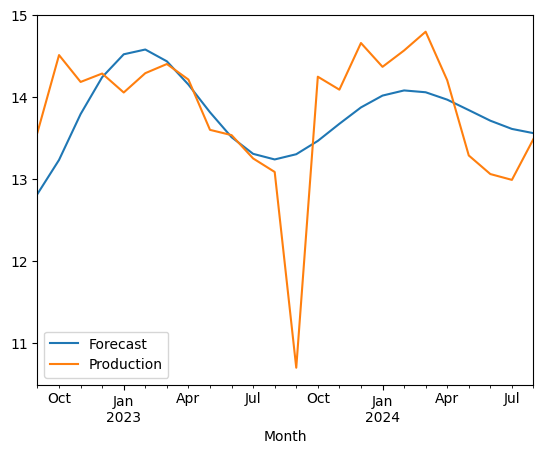

In [44]:
Model(prod_train, prod_test, (4, 0, 1))

Actual: 13.569762181863217, Predicted: 12.468228439975778
Actual: 14.512411683647114, Predicted: 12.867171802413612
Actual: 14.184932512458685, Predicted: 13.48746839265269
Actual: 14.287478506670679, Predicted: 14.179450484679801
Actual: 14.056266103595256, Predicted: 14.761997169022333
Actual: 14.291785108816498, Predicted: 15.080558520544207
Actual: 14.403353332403334, Predicted: 15.050458602241239
Actual: 14.21375969345213, Predicted: 14.67990099536786
Actual: 13.600935194664912, Predicted: 14.06784185351133
Actual: 13.53666598617865, Predicted: 13.377587406657101
Actual: 13.252482454697352, Predicted: 12.793226585139031
Actual: 13.087654948566668, Predicted: 12.470536139854921
Actual: 10.701422584813201, Predicted: 12.49545452187787
Actual: 14.248800279393093, Predicted: 12.861194991768684
Actual: 14.09079636319789, Predicted: 13.470093260961193
Actual: 14.65946368811532, Predicted: 14.15968689794648
Actual: 14.36921749439863, Predicted: 14.746062507012372
Actual: 14.5683256675619

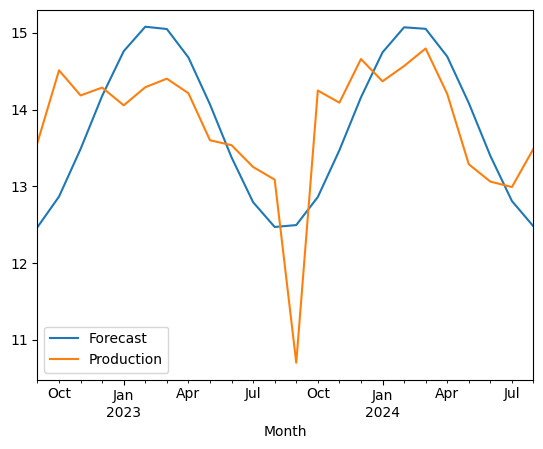

In [45]:
Model(prod_train, prod_test, (3, 0, 2))

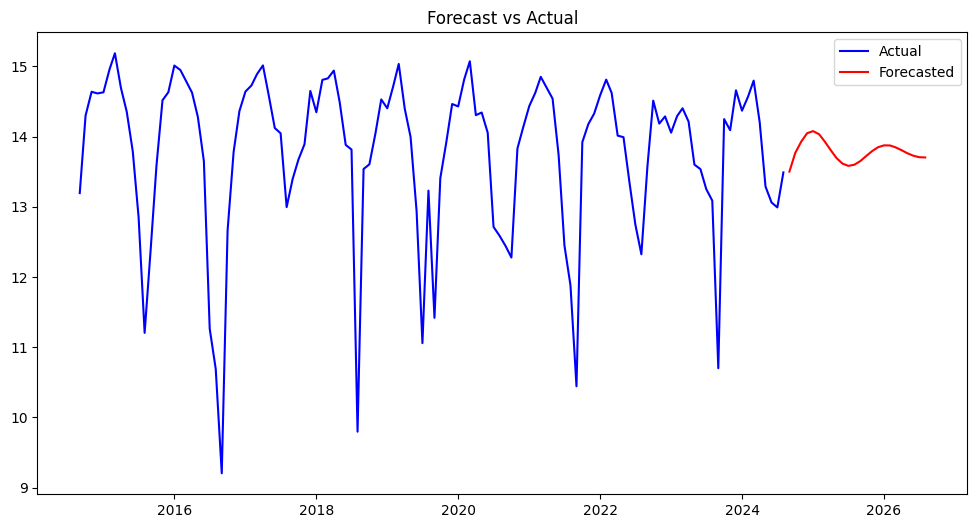

2024-09-01    13.500843
2024-10-01    13.766568
2024-11-01    13.928938
2024-12-01    14.047567
2025-01-01    14.077974
2025-02-01    14.032993
2025-03-01    13.932878
2025-04-01    13.809751
2025-05-01    13.695635
2025-06-01    13.615716
2025-07-01    13.583350
2025-08-01    13.598811
2025-09-01    13.651211
2025-10-01    13.722733
2025-11-01    13.793833
2025-12-01    13.848046
2026-01-01    13.875343
2026-02-01    13.873484
2026-03-01    13.847346
2026-04-01    13.806710
2026-05-01    13.763235
2026-06-01    13.727460
2026-07-01    13.706528
2026-08-01    13.703042
Freq: MS, Name: Forecast, dtype: float64

In [47]:
forecast = Forecast(log_production, (4, 0, 1), 24)
Forecasted_plot(log_production, forecast)
forecast

In [ ]:
orginal_forecast = exp(forecast)
Forecasted_plot(production, orginal_forecast)
orginal_forecast.apply(lambda x: f"{x:.2f}")